# Machine Translation (Seq2Seq) - RNN and Attention
Members
* Linda Sekhoasha - 222004139
* Wandile Ngobese - 222056013
* Khonzinkosi Mkhize - 219005273
* Samukelo Mkhize - 220009930

## Pip Commands & Imports (run once per runtime)

In [ ]:
# Core utilities
!pip install pandas

# Matching NLP/ML stack
!pip install evaluate datasets==2.18.0 transformers==4.39.3 sentencepiece==0.1.99

# English tokenizer for spaCy
!python -m spacy download en_core_web_sm

# Downgrade NumPy for compatibility with evaluate/datasets
!pip uninstall -y numpy
!pip install numpy==2.3.0

# Clean install of core torch packages
!pip uninstall -y torch torchtext torchaudio torchvision
!pip install torch==2.2.0 torchaudio==2.2.0 torchvision==0.17.0 torchtext==0.17.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 122.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 71.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.9/170.9 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 113.8 MB/s eta 0:00:00
  Attempting uninstall: sentencepiece
    Found existing installation: sentencepiece 0.2.0
    Uninstalling sentencepiece-0.2.0:
      Successfully uninstalled sentencepiece-0.2.0
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.1
    Uninstalling to

Found existing installation: torch 2.6.0+cu124
Uninstalling torch-2.6.0+cu124:
  Successfully uninstalled torch-2.6.0+cu124
Found existing installation: torchaudio 2.6.0+cu124
Uninstalling torchaudio-2.6.0+cu124:
  Successfully uninstalled torchaudio-2.6.0+cu124
Found existing installation: torchvision 0.21.0+cu124
Uninstalling torchvision-0.21.0+cu124:
  Successfully uninstalled torchvision-0.21.0+cu124
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 92.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 86.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 123.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 99.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import torch
print("Torch version:", torch.__version__)

Torch version: 2.2.0+cu121


In [ ]:
import torchtext
print("TorchText version:", torchtext.__version__)

TorchText version: 0.17.0+cpu


In [ ]:
import torchvision
print("TorchText version:", torchvision.__version__)

TorchText version: 0.17.0+cu121


In [ ]:
import torchaudio
print("TorchText version:", torchaudio.__version__)

TorchText version: 2.2.0+cu121


In [ ]:
import transformers
from transformers import M2M100ForConditionalGeneration, M2M100Tokenizer
import evaluate

In [ ]:
import numpy as np
print(np.__version__)

2.3.0


In [ ]:
# Standard library
import string
import random
from collections import Counter

# Scientific computing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
from torchtext.vocab import Vocab, build_vocab_from_iterator

# Hugging Face datasets, evaluation & tranfsormer model
import datasets
from datasets import load_dataset
import evaluate
from transformers import M2M100ForConditionalGeneration, M2M100Tokenizer

# NLP
import spacy

# Progress bar
import tqdm


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

In [ ]:
# Load English tokenizer (used for both English and Zulu for now)
en_nlp = spacy.load("en_core_web_sm")
zu_nlp = en_nlp  # TODO: Replace with actual Zulu tokenizer if available

# Data Preparation
Used Xhosa Corpus [XhosaNavy](https://opus.nlpl.eu/XhosaNavy/en&xh/v1/XhosaNavy). Xhosa is similar to Zulu, so the semantics are the same. The dataset was preferred as it is cleaner than any [Zulu](https://huggingface.co/datasets/LindaSekhoasha/zu-en_parallel-corpus_xsm) datasets we could find in the time constraint we had.

In [ ]:
# Load parallel corpus (Xhosa ↔ English) from Hugging Face
dataset = datasets.load_dataset("LindaSekhoasha/xh-en_parallel_corpus")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


## Dataset Splitting

In [ ]:
# Split 'train' into 80% training and 20% temporary test/validation
split_dataset = dataset["train"].train_test_split(test_size=0.2, seed=42)

# Split the 20% into 50% validation and 50% test (i.e., 10% each of total)
test_valid = split_dataset["test"].train_test_split(test_size=0.5, seed=42)

# Final dataset assignments
train_data = split_dataset["train"]
valid_data = test_valid["train"]
test_data = test_valid["test"]

# Confirm dataset structure
print(train_data.features)
print(valid_data.features)
print(test_data.features)

{'xh': Value(dtype='string', id=None), 'en': Value(dtype='string', id=None)}
{'xh': Value(dtype='string', id=None), 'en': Value(dtype='string', id=None)}
{'xh': Value(dtype='string', id=None), 'en': Value(dtype='string', id=None)}


## Tokenize Function

The `tokenize_example` function processes each parallel example from the dataset by:

- Tokenizing the English (`"en"`) and Xhosa/Zulu (`"xh"`) text using SpaCy.
- Truncating each token list to a maximum length.
- Optionally converting tokens to lowercase.
- Adding special `<sos>` (start-of-sentence) and `<eos>` (end-of-sentence) tokens.
- Returning a dictionary containing the tokenized output for both languages: `{"en_tokens": ..., "zu_tokens": ...}`.

This prepares the text for vocabulary building and numerical encoding in a sequence-to-sequence model.


In [ ]:
def tokenize_example(example, en_nlp, zu_nlp, max_length, lower, sos_token, eos_token):
    en_tokens = [token.text for token in en_nlp.tokenizer(example["en"])][:max_length]
    zu_tokens = [token.text for token in zu_nlp.tokenizer(example["xh"])][:max_length]
    if lower:
        en_tokens = [token.lower() for token in en_tokens]
        zu_tokens = [token.lower() for token in zu_tokens]
    en_tokens = [sos_token] + en_tokens + [eos_token]
    zu_tokens = [sos_token] + zu_tokens + [eos_token]
    return {"en_tokens": en_tokens, "zu_tokens": zu_tokens}

In [ ]:
max_length = 1_000
lower = True
sos_token = "<sos>"
eos_token = "<eos>"

fn_kwargs = {
    "en_nlp": en_nlp,
    "zu_nlp": zu_nlp,
    "max_length": max_length,
    "lower": lower,
    "sos_token": sos_token,
    "eos_token": eos_token,
}

# Apply the tokenization
train_data = train_data.map(tokenize_example, fn_kwargs=fn_kwargs)
valid_data = valid_data.map(tokenize_example, fn_kwargs=fn_kwargs)
test_data = test_data.map(tokenize_example, fn_kwargs=fn_kwargs)

Map:   0%|          | 0/2851 [00:00<?, ? examples/s]

Map:   0%|          | 0/2851 [00:00<?, ? examples/s]

In [ ]:
# Show first example
train_data[0]

{'xh': 'Kananjalo kulithintela ekutyhaleni nangakweliphi icala lokuhamba kwalo',
 'en': 'It also prevents her from sheering to either side of her course.',
 'en_tokens': ['<sos>',
  'it',
  'also',
  'prevents',
  'her',
  'from',
  'sheering',
  'to',
  'either',
  'side',
  'of',
  'her',
  'course',
  '.',
  '<eos>'],
 'zu_tokens': ['<sos>',
  'kananjalo',
  'kulithintela',
  'ekutyhaleni',
  'nangakweliphi',
  'icala',
  'lokuhamba',
  'kwalo',
  '<eos>']}

## Vocabulary Construction and Special Token Handling

This block builds separate vocabularies for English and Xhosa/Zulu token sequences using the training data.
- Only tokens appearing at least twice (`min_freq = 2`) are included.
- Special tokens `<unk>` (unknown) and `<pad>` (padding) are added to both vocabularies.
- It asserts that both vocabularies assign the same indices to these special tokens — this ensures consistency during padding, masking, and embedding lookup.
- Finally, it stores the indices of `<unk>` and `<pad>` for later use in model input preparation.


In [ ]:
# Vocab Parameters
min_freq = 2
unk_token = "<unk>"
pad_token = "<pad>"

special_tokens = [unk_token, pad_token]

# Vocab Construction
en_vocab = torchtext.vocab.build_vocab_from_iterator(
    train_data["en_tokens"],
    min_freq=min_freq,
    specials=special_tokens,
)

zu_vocab = torchtext.vocab.build_vocab_from_iterator(
    train_data["zu_tokens"],
    min_freq=min_freq,
    specials=special_tokens,
)

# Ensure Special Token Index Consistency
assert en_vocab[unk_token] == zu_vocab[unk_token], "Mismatch in <unk> token index"
assert en_vocab[pad_token] == zu_vocab[pad_token], "Mismatch in <pad> token index"

# Store Special Token Indices
unk_index = en_vocab[unk_token]
pad_index = en_vocab[pad_token]

In [ ]:
# Set the default index for unknown tokens (important!)
'''
This step ensures that any out-of-vocabulary (OOV) tokens encountered
during token-to-index conversion are automatically mapped to the '<unk>' index.
'''
en_vocab.set_default_index(unk_index)
zu_vocab.set_default_index(unk_index)

## Token-to-Index Conversion

The `numericalize_example` function maps tokenized words (`en_tokens`, `zu_tokens`) to their corresponding integer indices using the vocabularies.

This prepares the sequences for conversion to tensors and eventual input to the model.


In [ ]:
# function to convert tokens in vocab to indices
def numericalize_example(example, en_vocab, zu_vocab):
    en_ids = en_vocab.lookup_indices(example["en_tokens"])
    zu_ids = zu_vocab.lookup_indices(example["zu_tokens"])
    return {"en_ids": en_ids, "zu_ids": zu_ids}

## Numericalization of Tokens

This step converts tokenized words into integer indices using the previously constructed vocabularies.

- Each token list (`en_tokens`, `zu_tokens`) is mapped to its corresponding list of indices.
- This is necessary to feed sequences into the neural network, which operates on numerical inputs.


In [ ]:
fn_kwargs = {"en_vocab": en_vocab, "zu_vocab": zu_vocab}

train_data = train_data.map(numericalize_example, fn_kwargs=fn_kwargs)
valid_data = valid_data.map(numericalize_example, fn_kwargs=fn_kwargs)
test_data = test_data.map(numericalize_example, fn_kwargs=fn_kwargs)

Map:   0%|          | 0/2851 [00:00<?, ? examples/s]

Map:   0%|          | 0/2851 [00:00<?, ? examples/s]

In [ ]:
# Display the new features in an example (zu_ids and en_ids)
train_data[0]

{'xh': 'Kananjalo kulithintela ekutyhaleni nangakweliphi icala lokuhamba kwalo',
 'en': 'It also prevents her from sheering to either side of her course.',
 'en_tokens': ['<sos>',
  'it',
  'also',
  'prevents',
  'her',
  'from',
  'sheering',
  'to',
  'either',
  'side',
  'of',
  'her',
  'course',
  '.',
  '<eos>'],
 'zu_tokens': ['<sos>',
  'kananjalo',
  'kulithintela',
  'ekutyhaleni',
  'nangakweliphi',
  'icala',
  'lokuhamba',
  'kwalo',
  '<eos>'],
 'en_ids': [3, 18, 38, 2040, 47, 29, 0, 9, 272, 75, 6, 47, 192, 4, 2],
 'zu_ids': [3, 286, 0, 0, 0, 88, 1972, 1087, 2]}

## Dataset Formatting for PyTorch

This step converts the numericalized token sequences (`en_ids`, `zu_ids`) into PyTorch tensors.

- The `.with_format()` method enables seamless use with PyTorch-based DataLoaders and models.
- Setting `output_all_columns=True` keeps access to original fields like raw text and tokens.
- We verify that the transformation worked by checking the type of a sample sequence.


In [ ]:
# Extract raw data (avoids NumPy formatting issues)
train_raw = train_data.with_format("python")
valid_raw = valid_data.with_format("python")
test_raw = test_data.with_format("python")

# Define tensor conversion function (only updates relevant fields)
def to_tensor(original, converted):
    original["en_ids"] = converted["en_ids"]
    original["zu_ids"] = converted["zu_ids"]
    original["attention_mask"] = converted["attention_mask"]
    return original

# Create tensor versions of en_ids, zu_ids, attention_mask
def convert(example):
    return {
        "en_ids": torch.tensor(example["en_ids"], dtype=torch.long),
        "zu_ids": torch.tensor(example["zu_ids"], dtype=torch.long),
        "attention_mask": torch.tensor(example["attention_mask"], dtype=torch.long)
        if "attention_mask" in example else None,
    }

train_tensor_fields = [convert(example) for example in train_raw]
valid_tensor_fields = [convert(example) for example in valid_raw]
test_tensor_fields = [convert(example) for example in test_raw]

# Merge tensors into full original examples
train_data = [to_tensor(orig, tens) for orig, tens in zip(train_raw, train_tensor_fields)]
valid_data = [to_tensor(orig, tens) for orig, tens in zip(valid_raw, valid_tensor_fields)]
test_data  = [to_tensor(orig, tens) for orig, tens in zip(test_raw,  test_tensor_fields)]

# Final check
print(type(train_data[0]["en_ids"]))  # <class 'torch.Tensor'>
print(train_data[0].keys())           # should include en_ids, zu_ids, attention_mask + all original fields

<class 'torch.Tensor'>
dict_keys(['xh', 'en', 'en_tokens', 'zu_tokens', 'en_ids', 'zu_ids', 'attention_mask'])


## Custom Collate Function for Batching

This function returns a `collate_fn` used by PyTorch DataLoaders to:

- Collect a batch of individual examples
- Pad each sequence (`en_ids`, `zu_ids`) to the same length in the batch
- Return a dictionary of padded sequences ready for model input

Padding ensures that all sequences in a batch are of equal length, which is required for efficient GPU processing.


In [ ]:
# Function to create a custom collate_fn for padding sequences in a batch
def get_collate_fn(pad_index):
    def collate_fn(batch):
        # Extract sequences
        batch_en_ids = [example["en_ids"] for example in batch]
        batch_zu_ids = [example["zu_ids"] for example in batch]

        # Pad sequences
        batch_en_ids = nn.utils.rnn.pad_sequence(batch_en_ids, padding_value=pad_index)
        batch_zu_ids = nn.utils.rnn.pad_sequence(batch_zu_ids, padding_value=pad_index)

        return {
            "en_ids": batch_en_ids,
            "zu_ids": batch_zu_ids,
        }

    return collate_fn

In [ ]:
# Create a PyTorch DataLoader with custom padding-based collate function
def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    return data_loader

In [ ]:
# Create data loaders
# Note: larger batch size needs more GPU power but trains faster
batch_size = 128

train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
valid_data_loader = get_data_loader(valid_data, batch_size, pad_index)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)

# RNN Model (LSTM)

## Encoder Architecture

The encoder module of our sequence-to-sequence architecture is implemented using a multi-layer Long Short-Term Memory (LSTM) network. Its role is to process the source language sequence (Xhosa or Zulu) and compress it into a fixed-dimensional hidden state that captures the sequence’s semantic and syntactic properties.

Each token is first mapped to a dense vector via an embedding layer. A dropout layer is applied for regularization, reducing the risk of overfitting during training. The embedded token sequence is then passed through a stack of LSTM layers, which update their hidden and cell states at each time step based on the current input and the past state. Only the final hidden and cell states from the topmost LSTM layer are retained — these summarize the entire input sequence and are used to initialize the decoder.

We implement this logic in code by defining an `Encoder` class that inherits from `torch.nn.Module`, a base class for all neural network components in PyTorch. Within the `__init__()` method, we initialize all necessary layers and configurations. This includes an embedding layer, a dropout module, and a multi-layer LSTM. These components are constructed using `nn.Embedding`, `nn.Dropout`, and `nn.LSTM`, respectively. The `super().__init__()` call ensures that the module properly inherits PyTorch functionality.

The encoder accepts the following hyperparameters:

- `input_dim`: the size of the input vocabulary. This also corresponds to the dimensionality of one-hot vectors used to index into the embedding table.
- `embedding_dim`: the size of the dense vectors that replace one-hot encodings. These embeddings capture semantic similarity between words in a lower-dimensional space.
- `hidden_dim`: the dimensionality of the hidden and cell states used by the LSTM. This determines the model’s capacity to capture temporal dependencies.
- `n_layers`: the number of LSTM layers in the encoder stack. More layers typically capture deeper contextual information.
- `dropout`: a regularization parameter controlling the dropout probability, applied to the embedding vectors before they enter the LSTM.

Although we do not go into detail about word embeddings in this section, it is worth noting that embeddings are a fundamental mechanism for representing words in continuous vector space. These vectors are typically learned during training and provide more meaningful representations than sparse one-hot vectors. For further reading on word embeddings, see Jurafsky and Martin (2021), or explore popular tutorials on Word2Vec, GloVe, and contextual embeddings.

This architecture follows the standard sequence-to-sequence design pattern described in Jurafsky and Martin (2021), where recurrent neural networks encode the temporal structure of a sentence into a context vector. The use of multi-layer LSTMs with dropout reflects best practices in deep learning for NLP, as advocated in foundational teachings by Andrew Ng and others.

**Reference:**  
Jurafsky, D., & Martin, J. H. (2021). *Speech and Language Processing: An Introduction to Natural Language Processing, Computational Linguistics and Speech Recognition* (3rd ed.). Prentice Hall.  
Andrew Ng, *Deep Learning Specialization*, Stanford University / DeepLearning.AI


In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, n_layers, dropout):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        # src = [src length, batch size]
        embedded = self.dropout(self.embedding(src))
        # embedded = [src length, batch size, embedding dim]
        outputs, (hidden, cell) = self.rnn(embedded)
        # outputs = [src length, batch size, hidden dim * n directions]
        # hidden = [n layers * n directions, batch size, hidden dim]
        # cell = [n layers * n directions, batch size, hidden dim]
        # outputs are always from the top hidden layer
        return hidden, cell

## Decoder Architecture

The decoder is the second half of the sequence-to-sequence architecture, responsible for generating the target language sentence (in this case, English) one token at a time. Like the encoder, it is implemented as a multi-layer Long Short-Term Memory (LSTM) network, but with key differences that enable autoregressive generation.

The decoder receives as input a single token at each time step — either the `<sos>` token at the start of decoding or the previous token generated during training or inference. The decoder maintains an internal hidden state and cell state, both of which are initialized using the final hidden and cell states from the encoder. This allows the decoder to condition its outputs on the full encoded representation of the source sequence.

Each input token is mapped to a dense vector via an embedding layer. A dropout layer is applied to the embeddings for regularization. These vectors are then passed through the LSTM network, which updates the hidden and cell states. The output from the LSTM is passed through a fully connected linear layer to project the hidden state to the size of the target vocabulary. The result is a vector of logits from which the most probable next token can be selected.

This process is repeated sequentially for each token in the output sequence. In contrast to the encoder, the decoder operates in a step-wise manner and returns both the prediction (logits over the target vocabulary) and the updated hidden and cell states at every time step. This recurrent setup is crucial for autoregressive decoding, allowing the model to build up a coherent output sequence based on past outputs and the source context.

In code, the decoder is implemented as a subclass of `torch.nn.Module`. It takes the following hyperparameters:

- `output_dim`: the size of the target vocabulary.
- `embedding_dim`: the dimensionality of the learned word embeddings for the target language.
- `hidden_dim`: the size of the LSTM's hidden and cell states.
- `n_layers`: the number of stacked LSTM layers used in the decoder.
- `dropout`: the dropout probability applied to the embedded input vectors.

Internally, the decoder uses `nn.Embedding`, `nn.LSTM`, and `nn.Linear` layers to implement the core logic. The dropout mechanism is realized with `nn.Dropout`. These components are standard in PyTorch and can be configured flexibly for different architectures. The output of the decoder at each step is a prediction over the vocabulary space and a pair of updated states that are used in the subsequent step.

In [ ]:
class Decoder(nn.Module):
    def __init__(self, output_dim, embedding_dim, hidden_dim, n_layers, dropout):
        super().__init__()
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.embedding = nn.Embedding(output_dim, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=dropout)
        self.fc_out = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, cell):
        input = input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input))
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        prediction = self.fc_out(output.squeeze(0))
        return prediction, hidden, cell

## Seq2Seq

## Sequence-to-Sequence (Seq2Seq) Model

The `Seq2Seq` class represents the full sequence-to-sequence architecture that combines the encoder and decoder into a single end-to-end model. It is implemented by subclassing `torch.nn.Module`, and manages the data flow between the encoder and decoder during training or inference.

Upon initialization, the model checks that the encoder and decoder are structurally compatible — specifically, that they have equal hidden dimensionality and the same number of recurrent layers. This is essential for correctly passing the encoder's final hidden and cell states as the initial states for the decoder.

During the forward pass, the model receives two inputs:
- `src`: a tensor containing the tokenized source sentence (Xhosa/Zulu), shaped as \([ \text{src\_len}, \text{batch\_size} ]\)
- `trg`: a tensor containing the ground-truth target sentence (English), shaped as \([ \text{trg\_len}, \text{batch\_size} ]\)

The model first encodes the `src` sequence using the encoder. The resulting hidden and cell states are used to initialize the decoder. The decoder is then run iteratively over the length of the target sequence, starting with the `<sos>` token as the first input.

At each time step \( t \), the decoder receives three inputs:
1. The input token for the current step
2. The hidden state from the previous step
3. The cell state from the previous step

The decoder produces a prediction over the target vocabulary. This prediction is stored in a tensor `outputs` which accumulates the results for all time steps.

To improve learning, the model uses *teacher forcing*, a technique where the actual target token is used as the next input instead of the model's own prediction. This is controlled by the `teacher_forcing_ratio`, a probability value that determines how often ground-truth tokens are used during training. If teacher forcing is disabled at a given step, the model uses its predicted token (`top1`) as the next input.

This architecture enables the model to learn mappings from input to output sequences in a supervised manner, effectively modeling complex dependencies across languages.

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

        assert encoder.hidden_dim == decoder.hidden_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"

    def forward(self, src, trg, teacher_forcing_ratio):
        batch_size = trg.shape[1]
        trg_length = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim

        outputs = torch.zeros(trg_length, batch_size, trg_vocab_size).to(self.device)

        hidden, cell = self.encoder(src)
        input = trg[0, :]

        for t in range(1, trg_length):
            output, hidden, cell = self.decoder(input, hidden, cell)
            outputs[t] = output

            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[t] if teacher_force else top1

        return outputs

## Model Instantiation

The model was instantiated with carefully selected hyperparameters that balance representational capacity and computational feasibility. The source and target vocabulary sizes were derived from the previously constructed vocabularies: `input_dim` corresponds to the size of the Xhosa/Zulu vocabulary, and `output_dim` to that of the English vocabulary.

Both the encoder and decoder used an embedding dimensionality of 256, which is a common setting that captures semantic relationships without incurring excessive computational cost. The hidden state dimensionality was set to 512, allowing the LSTM units to store richer sequential information. Two recurrent layers (`n_layers = 2`) were used in both the encoder and decoder to enable hierarchical feature extraction, which has been shown to improve generalization in deep sequence modeling tasks (Sutskever et al., 2014).

Dropout regularization was applied independently in the encoder and decoder, each with a dropout probability of 0.5. This helps reduce overfitting by randomly deactivating neurons during training (Srivastava et al., 2014).

The encoder and decoder were instantiated separately and then passed into the `Seq2Seq` wrapper class. The complete model was moved to GPU (if available) using PyTorch’s `torch.device()` interface. This setup allows for efficient tensor operations and training acceleration on CUDA-compatible hardware.

This configuration serves as the baseline LSTM model. All subsequent training and evaluation are performed using this architecture unless otherwise specified.

**References:**  
Sutskever, I., Vinyals, O., & Le, Q. V. (2014). Sequence to sequence learning with neural networks. *Advances in Neural Information Processing Systems*, 27.  
Srivastava, N., Hinton, G., Krizhevsky, A., Sutskever, I., & Salakhutdinov, R. (2014). Dropout: A simple way to prevent neural networks from overfitting. *Journal of Machine Learning Research*, 15(1), 1929–1958.


In [ ]:
input_dim = len(zu_vocab)
output_dim = len(en_vocab)
encoder_embedding_dim = 256
decoder_embedding_dim = 256
hidden_dim = 512
n_layers = 2
encoder_dropout = 0.5
decoder_dropout = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = Encoder(
    input_dim,
    encoder_embedding_dim,
    hidden_dim,
    n_layers,
    encoder_dropout,
)

decoder = Decoder(
    output_dim,
    decoder_embedding_dim,
    hidden_dim,
    n_layers,
    decoder_dropout,
)

model = Seq2Seq(encoder, decoder, device).to(device)

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)


model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(14235, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(8054, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (fc_out): Linear(in_features=512, out_features=8054, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 17,194,102 trainable parameters


## Optimization and Loss Function

The model is trained using the Adam optimizer, a widely used adaptive learning rate algorithm that combines the benefits of RMSProp and momentum (Kingma and Ba, 2015). Adam is particularly effective for training deep neural networks on noisy or sparse gradients, as is often the case in natural language processing.

For the loss function, we employ the categorical cross-entropy loss (`nn.CrossEntropyLoss`) to measure the difference between the predicted and actual target tokens at each time step. This loss function is suitable for multi-class classification tasks where each output corresponds to a probability distribution over a vocabulary. Importantly, we configure the loss function to ignore the `<pad>` token index using the `ignore_index` parameter. This ensures that padded positions in the target sequences do not contribute to the loss during training, thereby preventing the model from learning to predict padding tokens and focusing instead on meaningful content.

Together, the optimizer and loss function form the foundation of the training loop, enabling the model to update its parameters via backpropagation.

**Reference:**  
Kingma, D. P., & Ba, J. (2015). Adam: A method for stochastic optimization. *International Conference on Learning Representations (ICLR)*.

In [ ]:
# optimizer
optimizer = optim.Adam(model.parameters())

# loss function
criterion = nn.CrossEntropyLoss(ignore_index=pad_index)

## Training Procedure

The model was trained using a mini-batch gradient descent loop implemented in the `train_fn` function. This function executes a forward and backward pass through the model for each batch in the training set and updates the model’s parameters using the Adam optimizer.

At each iteration, the input (`src`) and target (`trg`) sequences are retrieved from the batch and moved to the appropriate device (GPU or CPU). The model generates predicted output sequences using the current parameters and the specified `teacher_forcing_ratio`, which determines the probability of using ground-truth tokens as input at each decoding step. The loss is computed using the categorical cross-entropy criterion, excluding padded tokens via the `ignore_index` setting.

To avoid exploding gradients — a common issue in training recurrent neural networks — we apply gradient clipping using PyTorch’s `clip_grad_norm_` function. This ensures that the norm of the gradients stays within a specified threshold (`clip`). After computing gradients via backpropagation, the optimizer updates the model parameters.

The function returns the average loss over all batches in the epoch, providing a quantitative measure of model performance during training.

In [ ]:
def train_fn(model, data_loader, optimizer, criterion, clip, teacher_forcing_ratio, device):
    model.train()
    epoch_loss = 0

    for batch in data_loader:
        src = batch["zu_ids"].to(device)
        trg = batch["en_ids"].to(device)

        optimizer.zero_grad()
        output = model(src, trg, teacher_forcing_ratio)

        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)

        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(data_loader)

## Evaluation Procedure

Model evaluation is performed using a function (`evaluate_fn`) that closely mirrors the training loop, but with key modifications to ensure that the model is assessed under inference-like conditions. Specifically, the model is switched to evaluation mode using `model.eval()`, which disables dropout layers and other training-specific behaviors. Additionally, all operations are wrapped in a `torch.no_grad()` context to prevent gradient computations, reducing memory usage and improving computational efficiency.

During evaluation, the decoder receives no ground-truth tokens; instead, it generates each token based solely on its previous predictions. This is achieved by setting the `teacher_forcing_ratio` to zero. The model outputs are reshaped to match the dimensions expected by the cross-entropy loss function, which computes the discrepancy between the predicted and actual target sequences. The loss is accumulated over all batches and averaged to yield a single scalar metric that reflects the model’s performance on the validation or test set.

This evaluation strategy provides a reliable estimate of the model’s generalization ability without influencing the model’s parameters.

In [ ]:
def evaluate_fn(model, data_loader, criterion, device):
    model.eval()
    epoch_loss = 0

    with torch.no_grad():
        for batch in data_loader:
            src = batch["zu_ids"].to(device)
            trg = batch["en_ids"].to(device)

            output = model(src, trg, 0)  # no teacher forcing
            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            loss = criterion(output, trg)
            epoch_loss += loss.item()

    return epoch_loss / len(data_loader)

## Epoch-Level Training Loop and Checkpointing

Model training is conducted over multiple epochs, with each epoch consisting of a complete pass through the training dataset. The number of epochs (`n_epochs`) was set to 10, and a gradient clipping threshold (`clip = 1.0`) was used to constrain the norm of gradients during backpropagation, reducing the risk of unstable updates.

During each epoch, the model undergoes training using the `train_fn` function, followed by evaluation on the validation set via `evaluate_fn`. The average losses from both procedures are recorded. To assess model confidence and track convergence more effectively, perplexity scores were computed by exponentiating the average loss values:

$$\text{Perplexity} = \exp(\text{Loss})$$

Perplexity provides an interpretable metric for language modeling, where lower values indicate better predictive performance.

A model checkpointing mechanism was incorporated to save the best-performing model based on validation loss. Specifically, the model's parameters are saved to disk (`tut1-model.pt`) only if the current epoch achieves a lower validation loss than any previous epoch. This ensures that the saved model generalizes well to unseen data.

All training and evaluation losses, as well as their corresponding perplexities, are stored in lists for post-training visualization. This allows for later plotting of learning curves, which is useful for diagnosing underfitting, overfitting, or training instability.


In [ ]:
n_epochs = 10
clip = 1.0
teacher_forcing_ratio = 0.5

best_valid_loss = float("inf")

# log variables for graph visualizations
train_losses = []
valid_losses = []
train_ppls = []
valid_ppls = []

for epoch in tqdm.tqdm(range(n_epochs)):
    train_loss = train_fn(
        model,
        train_data_loader,
        optimizer,
        criterion,
        clip,
        teacher_forcing_ratio,
        device,
    )
    valid_loss = evaluate_fn(
        model,
        valid_data_loader,
        criterion,
        device,
    )
    # save the model only if validation loss improves
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "tut1-model.pt")

    # perplexity calculation
    train_ppl = np.exp(train_loss)
    valid_ppl = np.exp(valid_loss)

    # log and track
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_ppls.append(train_ppl)
    valid_ppls.append(valid_ppl)

    print(f"\tTrain Loss: {train_loss:7.3f} | Train PPL: {train_ppl:7.3f}")
    print(f"\tValid Loss: {valid_loss:7.3f} | Valid PPL: {valid_ppl:7.3f}")

 10%|█         | 1/10 [00:18<02:44, 18.26s/it]

	Train Loss:   6.070 | Train PPL: 432.737
	Valid Loss:   5.825 | Valid PPL: 338.732


 20%|██        | 2/10 [00:36<02:23, 17.99s/it]

	Train Loss:   5.737 | Train PPL: 310.273
	Valid Loss:   5.832 | Valid PPL: 340.930


 30%|███       | 3/10 [00:54<02:06, 18.05s/it]

	Train Loss:   5.584 | Train PPL: 266.076
	Valid Loss:   5.677 | Valid PPL: 292.086


 40%|████      | 4/10 [01:12<01:47, 17.98s/it]

	Train Loss:   5.381 | Train PPL: 217.149
	Valid Loss:   5.570 | Valid PPL: 262.543


 50%|█████     | 5/10 [01:30<01:30, 18.01s/it]

	Train Loss:   5.216 | Train PPL: 184.270
	Valid Loss:   5.546 | Valid PPL: 256.164


 60%|██████    | 6/10 [01:48<01:12, 18.01s/it]

	Train Loss:   5.087 | Train PPL: 161.970
	Valid Loss:   5.510 | Valid PPL: 247.133


 70%|███████   | 7/10 [02:05<00:53, 17.95s/it]

	Train Loss:   4.975 | Train PPL: 144.680
	Valid Loss:   5.512 | Valid PPL: 247.688


 80%|████████  | 8/10 [02:23<00:35, 17.96s/it]

	Train Loss:   4.862 | Train PPL: 129.317
	Valid Loss:   5.503 | Valid PPL: 245.415


 90%|█████████ | 9/10 [02:41<00:17, 17.96s/it]

	Train Loss:   4.756 | Train PPL: 116.245
	Valid Loss:   5.462 | Valid PPL: 235.626


100%|██████████| 10/10 [02:59<00:00, 17.99s/it]

	Train Loss:   4.651 | Train PPL: 104.728
	Valid Loss:   5.511 | Valid PPL: 247.480


## Graphs and Visualizations

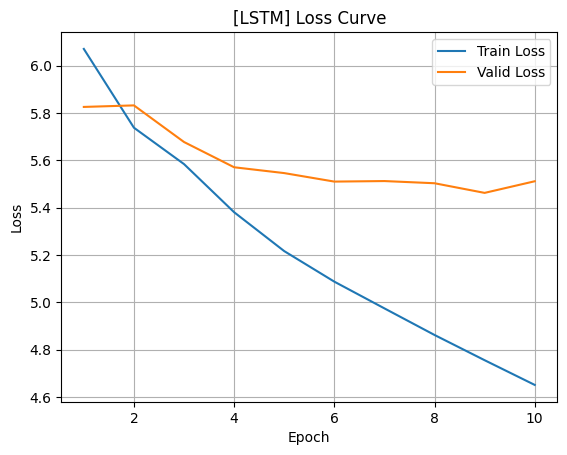

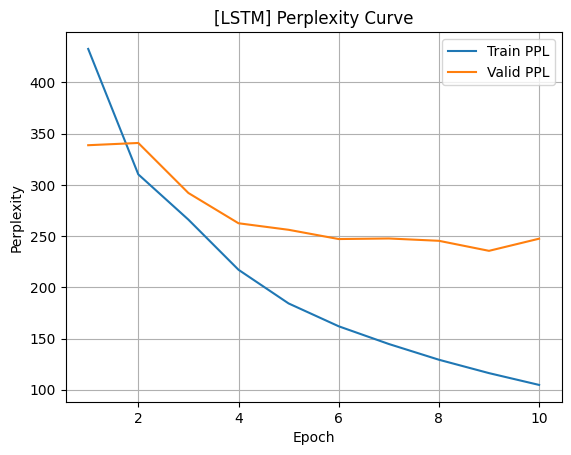

In [ ]:
epochs = range(1, n_epochs + 1)

# plot Loss
plt.figure()
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, valid_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('[LSTM] Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

# plot Perplexity
plt.figure()
plt.plot(epochs, train_ppls, label='Train PPL')
plt.plot(epochs, valid_ppls, label='Valid PPL')
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.title('[LSTM] Perplexity Curve')
plt.legend()
plt.grid(True)
plt.show()

## RNN Model Evaluation

In [ ]:
model.load_state_dict(torch.load("tut1-model.pt"))

test_loss = evaluate_fn(model, test_data_loader, criterion, device)

print(f"| Test Loss: {test_loss:.3f} | Test PPL: {np.exp(test_loss):7.3f} |")

| Test Loss: 5.459 | Test PPL: 234.817 |


## Inference: Translating Sentences

To evaluate the model qualitatively, we define a function `translate_sentence()` that takes a raw Xhosa or Zulu input sentence and returns a translated English sentence using greedy decoding.

The function performs the following steps:

1. **Tokenization and Preprocessing**  
   The input sentence is tokenized using the SpaCy tokenizer (same as used during training). Tokens are lowercased (if enabled), and wrapped with start (`<sos>`) and end (`<eos>`) tokens. These tokens are then converted to integer indices via the source vocabulary and converted into a PyTorch tensor.

2. **Encoding**  
   The token indices are passed into the encoder to obtain the initial hidden and cell states that summarize the source sentence.

3. **Greedy Decoding**  
   The decoder is initialized with the `<sos>` token and generates one token at a time. At each time step, the token with the highest probability is selected using `argmax`, and the decoding process continues until the `<eos>` token is predicted or a maximum output length is reached.

4. **Output Postprocessing**  
   The output token indices are mapped back into readable English words using the target vocabulary.

The decoding process is performed without teacher forcing, thus simulating a real inference scenario.

In [ ]:
def translate_sentence(
    sentence,
    model,
    en_nlp,
    zu_nlp,
    en_vocab,
    zu_vocab,
    lower,
    sos_token,
    eos_token,
    device,
    max_output_length=25,
):
    model.eval()
    with torch.no_grad():
        if isinstance(sentence, str):
            tokens = [token.text for token in zu_nlp.tokenizer(sentence)]
        else:
            tokens = [token for token in sentence]
        if lower:
            tokens = [token.lower() for token in tokens]
        tokens = [sos_token] + tokens + [eos_token]
        ids = zu_vocab.lookup_indices(tokens)
        tensor = torch.LongTensor(ids).unsqueeze(-1).to(device)
        hidden, cell = model.encoder(tensor)
        inputs = en_vocab.lookup_indices([sos_token])
        for _ in range(max_output_length):
            inputs_tensor = torch.LongTensor([inputs[-1]]).to(device)
            output, hidden, cell = model.decoder(inputs_tensor, hidden, cell)
            predicted_token = output.argmax(-1).item()
            inputs.append(predicted_token)
            if predicted_token == en_vocab[eos_token]:
                break
        tokens = en_vocab.lookup_tokens(inputs)
    return tokens

In [ ]:
print(test_data[0].keys())

dict_keys(['xh', 'en', 'en_tokens', 'zu_tokens', 'en_ids', 'zu_ids', 'attention_mask'])


In [ ]:
sentence = test_data[0]["xh"]
expected_translation = test_data[0]["en"]

sentence, expected_translation

('Le ntambo iye iqiniswe kwangoko kude kwicala elijongene nomoya.',
 'This line is immediately made fast far to windward.')

In [ ]:
translations = [
    translate_sentence(
        example["xh"],
        model,
        en_nlp,
        zu_nlp,
        en_vocab,
        zu_vocab,
        lower,
        sos_token,
        eos_token,
        device,
    )
    for example in tqdm.tqdm(test_data)
]

100%|██████████| 2851/2851 [00:14<00:00, 191.88it/s]


In [ ]:
bleu = evaluate.load("bleu")

In [ ]:
# Format both the model predictions and ground-truth references appropriately
predictions = [" ".join(translation[1:-1]) for translation in translations]

references = [[example["en"]] for example in test_data]

In [ ]:
predictions[0], references[0]

('this is the the the the the the the the . .',
 ['This line is immediately made fast far to windward.'])

In [ ]:
# Tokenizer Wrapper Function
def get_tokenizer_fn(nlp, lower):
    def tokenizer_fn(s):
        tokens = [token.text for token in nlp.tokenizer(s)]
        if lower:
            tokens = [token.lower() for token in tokens]
        return tokens

    return tokenizer_fn

In [ ]:
tokenizer_fn = get_tokenizer_fn(en_nlp, lower)

In [ ]:
tokenizer_fn(predictions[0]), tokenizer_fn(references[0][0])

(['this',
  'is',
  'the',
  'the',
  'the',
  'the',
  'the',
  'the',
  'the',
  'the',
  '.',
  '.'],
 ['this',
  'line',
  'is',
  'immediately',
  'made',
  'fast',
  'far',
  'to',
  'windward',
  '.'])

In [ ]:
results = bleu.compute(
    predictions=predictions, references=references, tokenizer=tokenizer_fn
)

results

{'bleu': 0.003914685207362122,
 'precisions': [0.21025066820775842,
  0.012513076365977307,
  0.0008622645790787384,
  0.00010352502717531963],
 'brevity_penalty': 1.0,
 'length_ratio': 1.0129147916438006,
 'translation_length': 27686,
 'reference_length': 27333}

# Attention Model

## Attention Mechanism

To enhance the decoder's ability to focus on relevant parts of the source sequence during translation, we incorporate an attention mechanism. This module computes a weighted sum over the encoder's outputs at each decoding step, allowing the model to dynamically attend to different parts of the input.

The attention module follows a formulation similar to the additive attention mechanism, as described in Bahdanau et al. (2015). It takes the current decoder hidden state and the full sequence of encoder outputs to compute attention scores, which are then normalized via a softmax layer.

### Key Components

- `self.attn`: A linear layer that combines the decoder's hidden state and the encoder output at each time step.
- `self.v`: A learnable parameter vector used to convert attention energies into scalar scores via a dot product.

### Forward Pass Description

1. The decoder's last-layer hidden state (`hidden`) is repeated across the source length dimension to align with `encoder_outputs`.
2. Both are concatenated and passed through a non-linear activation (tanh) and a linear projection.
3. The attention energies are then computed as a dot product with the learnable parameter `v`.
4. A softmax is applied to obtain attention weights over the source tokens.

This results in a context vector that can be used by the decoder to selectively incorporate information from the source sequence, enabling more accurate translations, particularly for longer or syntactically complex sentences.

This design is consistent with the alignment-based methods described by Jurafsky and Martin (2021) and widely used in modern sequence-to-sequence architectures.

In [ ]:
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attn = nn.Linear(hidden_dim * 2, hidden_dim)
        self.v = nn.Parameter(torch.rand(hidden_dim))

    def forward(self, hidden, encoder_outputs):
        if hidden.dim() == 3:
            hidden = hidden[-1]  # [batch_size, hidden_dim]

        src_len = encoder_outputs.shape[0]  # [src_len, batch_size, hidden_dim]
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)  # [batch_size, src_len, hidden_dim]
        encoder_outputs = encoder_outputs.permute(1, 0, 2)  # [batch_size, src_len, hidden_dim]

        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))  # [batch_size, src_len, hidden_dim]
        energy = energy.permute(0, 2, 1)  # [batch_size, hidden_dim, src_len]

        v = self.v.repeat(encoder_outputs.size(0), 1).unsqueeze(1)  # [batch_size, 1, hidden_dim]
        attention = torch.bmm(v, energy).squeeze(1)  # [batch_size, src_len]
        return torch.softmax(attention, dim=1)  # [batch_size, src_len]

## Attention-Based Decoder

To complement the encoder with a context-aware decoding process, we implement an attention-based decoder (`AttnDecoder`). This module extends the baseline LSTM decoder by integrating a dynamic context vector derived from the attention mechanism.

### Architectural Overview

- **Embedding Layer**: Converts target token indices into dense vector representations.
- **Attention Layer**: Computes attention weights between the decoder's current hidden state and all encoder outputs. This allows the decoder to "attend" to different parts of the source sequence dynamically at each time step.
- **Context Vector (Weighted Sum)**: A weighted sum of encoder outputs is calculated based on attention scores, producing a context vector.
- **LSTM Input**: The embedded input token is concatenated with the context vector and passed into the LSTM.
- **Linear Output Projection**: The output of the LSTM is combined with the context vector and passed through a linear layer to generate token scores over the target vocabulary.

### Forward Pass Semantics

1. The decoder receives the previous token’s index, current hidden and cell states, and the full sequence of encoder outputs.
2. The attention scores are computed by comparing the current decoder state with each encoder output.
3. These scores are used to compute a weighted context vector via batch matrix multiplication.
4. The LSTM is fed the concatenation of the current embedded token and the context vector.
5. The decoder then predicts the next token using a linear transformation of the concatenated LSTM output and context vector.

This structure allows the decoder to align with the most relevant source tokens at each generation step, improving translation fidelity — especially in long or syntactically complex sequences.

This approach reflects the attention-enhanced sequence models described in Jurafsky and Martin (2021), and builds on the additive attention method from Bahdanau et al. (2015).


In [ ]:
class AttnDecoder(nn.Module):
    def __init__(self, output_dim, embedding_dim, hidden_dim, n_layers, dropout, attention):
        super().__init__()
        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim + hidden_dim, hidden_dim, n_layers, dropout=dropout)
        self.fc_out = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, cell, encoder_outputs):
        input = input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input))
        a = self.attention(hidden[-1], encoder_outputs)
        a = a.unsqueeze(1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        weighted = torch.bmm(a, encoder_outputs)
        weighted = weighted.permute(1, 0, 2)
        rnn_input = torch.cat((embedded, weighted), dim=2)
        output, (hidden, cell) = self.rnn(rnn_input, (hidden, cell))
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        prediction = self.fc_out(torch.cat((output, weighted), dim=1))
        return prediction, hidden, cell

## Attention-Based Sequence-to-Sequence Model

The `AttnSeq2Seq` class integrates an attention-equipped decoder into the traditional sequence-to-sequence architecture. This allows the decoder to dynamically reference specific encoder outputs during generation, instead of relying solely on the final hidden state.

### Model Structure

- **Encoder**: Processes the input sequence and outputs both the final hidden states and the full sequence of intermediate outputs, which are needed for attention.
- **Attention Decoder**: At each time step, the decoder uses the current hidden state to compute attention weights over the encoder outputs. This enables context-aware decoding.
- **Device Configuration**: The model is configured to run on either CPU or GPU, depending on availability.

### Forward Pass Workflow

1. **Initialization**: A tensor `outputs` is initialized to store token-level predictions at each time step.
2. **Encoding**: The input sequence is passed through the encoder to obtain hidden and cell states. The full sequence of encoder outputs is also retained to support attention.
3. **Decoding**:
   - The decoder begins with the `<sos>` token as input.
   - For each time step, the decoder uses the current input token, the hidden and cell states, and the encoder outputs to generate:
     - The next output prediction (token scores).
     - Updated hidden and cell states.
   - Teacher forcing is optionally applied: with probability `teacher_forcing_ratio`, the true token is used as the next input; otherwise, the model's own prediction is used.

### Purpose and Benefit

This architecture allows the decoder to make informed decisions by attending to different parts of the source sentence. It is especially beneficial in handling long-range dependencies, which standard encoder-decoder models struggle with. This setup closely mirrors the architecture proposed by Bahdanau et al. (2015) and is grounded in the broader framework of attention-based neural machine translation described in Jurafsky and Martin (2021).

In [ ]:
class AttnSeq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        hidden, cell = self.encoder(src)
        encoder_outputs, _ = self.encoder.rnn(self.encoder.embedding(src))
        input = trg[0, :]
        for t in range(1, trg_len):
            output, hidden, cell = self.decoder(input, hidden, cell, encoder_outputs)
            outputs[t] = output
            top1 = output.argmax(1)
            input = trg[t] if random.random() < teacher_forcing_ratio else top1
        return outputs

## Training the Attention-Based Model

To evaluate the benefits of attention, we train a second sequence-to-sequence model that incorporates an attention mechanism within the decoder.

### Model Initialization

We instantiate the following components:

- `Attention`: The attention module is initialized using the `hidden_dim` from the LSTM layers.
- `AttnDecoder`: The decoder is extended with an attention mechanism that receives both the current decoder state and the encoder outputs at each time step.
- `AttnSeq2Seq`: The encoder is combined with the attention-equipped decoder into a unified model.

Weight initialization is applied using a custom `init_weights` function to ensure consistent parameter scaling before training. The loss function and optimizer remain unchanged from the non-attention model.

In [ ]:
attention = Attention(hidden_dim)
decoder_attn = AttnDecoder(
    output_dim, decoder_embedding_dim, hidden_dim, n_layers, decoder_dropout, attention
)
model_attn = AttnSeq2Seq(encoder, decoder_attn, device).to(device)
model_attn.apply(init_weights)
optimizer_attn = optim.Adam(model_attn.parameters())
criterion_attn = nn.CrossEntropyLoss(ignore_index=pad_index)

train_losses_attn = []
valid_losses_attn = []
train_ppls_attn = []
valid_ppls_attn = []

best_valid_loss_attn = float("inf")

for epoch in tqdm.tqdm(range(n_epochs)):
    train_loss = train_fn(model_attn, train_data_loader, optimizer_attn, criterion_attn, clip, teacher_forcing_ratio, device)
    valid_loss = evaluate_fn(model_attn, valid_data_loader, criterion_attn, device)

    if valid_loss < best_valid_loss_attn:
        best_valid_loss_attn = valid_loss
        torch.save(model_attn.state_dict(), "attn-model.pt")

    train_ppl = np.exp(train_loss)
    valid_ppl = np.exp(valid_loss)

    train_losses_attn.append(train_loss)
    valid_losses_attn.append(valid_loss)
    train_ppls_attn.append(train_ppl)
    valid_ppls_attn.append(valid_ppl)

    print(f"[Attn] Train Loss: {train_loss:.3f} | Train PPL: {train_ppl:.3f}")
    print(f"[Attn] Valid Loss: {valid_loss:.3f} | Valid PPL: {valid_ppl:.3f}")

 10%|█         | 1/10 [00:25<03:52, 25.79s/it]

[Attn] Train Loss: 5.964 | Train PPL: 389.028
[Attn] Valid Loss: 5.677 | Valid PPL: 291.989


 20%|██        | 2/10 [00:51<03:24, 25.52s/it]

[Attn] Train Loss: 5.487 | Train PPL: 241.576
[Attn] Valid Loss: 5.561 | Valid PPL: 260.072


 30%|███       | 3/10 [01:16<02:59, 25.63s/it]

[Attn] Train Loss: 5.204 | Train PPL: 182.029
[Attn] Valid Loss: 5.400 | Valid PPL: 221.326


 40%|████      | 4/10 [01:42<02:33, 25.63s/it]

[Attn] Train Loss: 4.899 | Train PPL: 134.187
[Attn] Valid Loss: 5.293 | Valid PPL: 199.000


 50%|█████     | 5/10 [02:08<02:08, 25.60s/it]

[Attn] Train Loss: 4.569 | Train PPL: 96.449
[Attn] Valid Loss: 5.206 | Valid PPL: 182.444


 60%|██████    | 6/10 [02:33<01:41, 25.48s/it]

[Attn] Train Loss: 4.257 | Train PPL: 70.585
[Attn] Valid Loss: 5.220 | Valid PPL: 184.876


 70%|███████   | 7/10 [02:58<01:16, 25.39s/it]

[Attn] Train Loss: 3.953 | Train PPL: 52.077
[Attn] Valid Loss: 5.241 | Valid PPL: 188.833


 80%|████████  | 8/10 [03:23<00:50, 25.41s/it]

[Attn] Train Loss: 3.662 | Train PPL: 38.942
[Attn] Valid Loss: 5.253 | Valid PPL: 191.169


 90%|█████████ | 9/10 [03:49<00:25, 25.39s/it]

[Attn] Train Loss: 3.349 | Train PPL: 28.468
[Attn] Valid Loss: 5.338 | Valid PPL: 208.177


100%|██████████| 10/10 [04:14<00:00, 25.49s/it]

[Attn] Train Loss: 3.094 | Train PPL: 22.073
[Attn] Valid Loss: 5.388 | Valid PPL: 218.745


## Graphs and Visualizations
To assess the training dynamics of the attention-enhanced model, we plot both the loss and perplexity curves over the full training period. These visualizations provide insights into model convergence, generalization, and potential overfitting or underfitting.

### Loss Curve

The loss values from both the training and validation sets are plotted across all epochs. A smooth, decreasing validation loss generally indicates successful learning, while a divergence between training and validation loss may suggest overfitting.

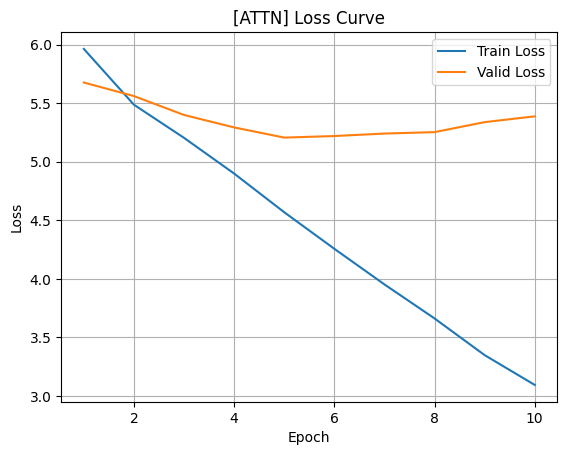

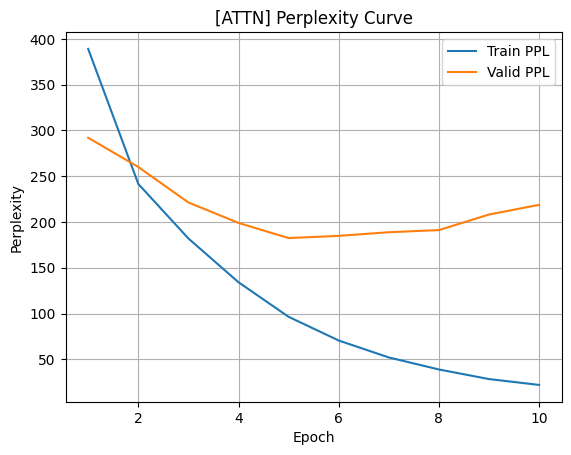

In [ ]:
epochs = range(1, n_epochs + 1)

# plot Loss
plt.figure()
plt.plot(epochs, train_losses_attn, label='Train Loss')
plt.plot(epochs, valid_losses_attn, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('[ATTN] Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

# plot Perplexity
plt.figure()
plt.plot(epochs, train_ppls_attn, label='Train PPL')
plt.plot(epochs, valid_ppls_attn, label='Valid PPL')
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.title('[ATTN] Perplexity Curve')
plt.legend()
plt.grid(True)
plt.show()

## BLEU Evaluation with Attention Model

To quantitatively assess translation performance, we apply BLEU (Bilingual Evaluation Understudy) scoring to the outputs of the attention-based model. BLEU is a widely used metric for evaluating the quality of machine-translated text by comparing n-gram overlap between predicted translations and human references.

### Inference Process

We define a translation function that takes an Xhosa/Zulu sentence and returns an English prediction:

- The input sentence is tokenized and converted to indices using the source vocabulary.
- The encoder processes the input to generate context-rich hidden states.
- The decoder generates the output sequence one token at a time, using the attention mechanism to focus on relevant source positions.

Predictions are collected from the model, and the true English references are retrieved from the test set.

In [ ]:
# Load best attention model weights
model_attn.load_state_dict(torch.load("attn-model.pt"))
model_attn.eval()

# Translate using the trained model
def translate_with_attention(example):
    sentence = example["xh"]
    tokens = [token.text for token in zu_nlp.tokenizer(sentence)]
    if lower:
        tokens = [t.lower() for t in tokens]
    tokens = [sos_token] + tokens + [eos_token]
    ids = zu_vocab.lookup_indices(tokens)
    src_tensor = torch.LongTensor(ids).unsqueeze(-1).to(device)

    with torch.no_grad():
        embedded = model_attn.encoder.embedding(src_tensor)
        encoder_outputs, (hidden, cell) = model_attn.encoder.rnn(embedded)
        input_token = torch.tensor([en_vocab[sos_token]]).to(device)

        predicted = []
        for _ in range(50):  # max output length
            output, hidden, cell = model_attn.decoder(
                input_token,
                hidden,
                cell,
                encoder_outputs
            )

            pred_token = output.argmax(-1).item()
            if pred_token == en_vocab[eos_token]:
                break
            predicted.append(pred_token)
            input_token = torch.tensor([pred_token]).to(device)

    pred_tokens = en_vocab.lookup_tokens(predicted)
    return " ".join(pred_tokens)


# Collect predictions and references
attn_predictions = [translate_with_attention(ex) for ex in test_data]
attn_references = [[ex["en"]] for ex in test_data]

In [ ]:
attn_predictions[0], attn_references[0]

('this anchor is then be the the the the the the .',
 ['This line is immediately made fast far to windward.'])

In [ ]:
# Compute BLEU
bleu_result_attn = bleu.compute(predictions=attn_predictions, references=attn_references, tokenizer=tokenizer_fn)

bleu_result_attn

{'bleu': 0.009740655361364665,
 'precisions': [0.28304203675657974,
  0.027386468952734014,
  0.0038204393505253103,
  0.0004888780249327792],
 'brevity_penalty': 0.8880000206369183,
 'length_ratio': 0.893827973511872,
 'translation_length': 24431,
 'reference_length': 27333}

# Pretrained Model

In [ ]:
# Load the model and tokenizer
m2m_model_name = "facebook/m2m100_418M"
m2m_tokenizer = M2M100Tokenizer.from_pretrained(m2m_model_name)
m2m_model = M2M100ForConditionalGeneration.from_pretrained(m2m_model_name).to(device)

# Set source language
m2m_tokenizer.src_lang = "xh"  # or "zu" for Zulu

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/298 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/3.71M [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.14k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/908 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.94G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/233 [00:00<?, ?B/s]

In [ ]:
# Translation function
def translate_with_m2m100(sentence):
    # Tokenize the input sentence
    encoded = m2m_tokenizer(sentence, return_tensors="pt").to(device)

    # Generate translation
    generated_tokens = m2m_model.generate(
        **encoded,
        forced_bos_token_id=m2m_tokenizer.get_lang_id("en"),  # Force target lang to English
        max_length=50
    )

    # Decode the output
    translation = m2m_tokenizer.decode(generated_tokens[0], skip_special_tokens=True)
    return translation

In [ ]:
m2m_predictions = [
    translate_with_m2m100(example["xh"]) for example in test_data
]


In [ ]:
index = 100

print(f"Attn:\n{attn_predictions[index]}\nm2m:\n{m2m_predictions[index]}\n")
print(f"reference:\n{attn_references[index]}")

Attn:
this is , , , the the the the the the the .
m2m:
As a result of this, it has been dismissed from the outskirts of the banks to the outskirts of the sunshine.

reference:
['For this reason, it is unwise to simply leave the victim in the leeward bunk.']


In [ ]:
bleu_result_m2m = bleu.compute(predictions=m2m_predictions, references=attn_references)
bleu_result_m2m

{'bleu': 0.04464077484816481,
 'precisions': [0.26061745807867104,
  0.055930336614579745,
  0.022381820945432437,
  0.012172521270322634],
 'brevity_penalty': 1.0,
 'length_ratio': 1.193424104137054,
 'translation_length': 31905,
 'reference_length': 26734}